In [1]:
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF, CountVectorizer, Normalizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, DoubleType, StringType, StructType, StructField
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
from nltk.sentiment import SentimentIntensityAnalyzer
from pyspark.ml import Pipeline, PipelineModel
import pyspark

# Data Retrieval

In [2]:
data_file = r"/home/jovyan/repos/distributed-sentiment-analysis-on-twitter-data/twitter_data_en/*.csv"
vader_analyzer = SentimentIntensityAnalyzer()

In [3]:
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '10g'),
                                   ('spark.driver.memory','10g'),
                                   ('spark.master', 'local[*]')])

# Initialize a Spark session
spark = SparkSession \
    .builder \
    .appName("SentimentAnalysis") \
    .config(conf=conf) \
    .getOrCreate()

sc = spark.sparkContext

In [4]:
sc.getConf().getAll()

[('spark.driver.host', 'de4f1c03e850'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.port', '34089'),
 ('spark.driver.memory', '10g'),
 ('spark.app.id', 'local-1524789619664'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.name', 'SentimentAnalysis'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
# define the data schema(format/structure) for our twitter data in the csv file
twitter_data_schema = StructType([StructField("date_str", StringType(), True),
                                  StructField("tweet_id", StringType(), True),
                                  StructField("text", StringType(), True),
                                  StructField("location", StringType(), True),
                                  StructField("user_id", StringType(), True),
                                  StructField("user_name", StringType(), True),
                                  StructField("user_location", StringType(), True),
                                  StructField("user_url", StringType(), True),
                                  StructField("user_description", StringType(), True),
                                  StructField("place_id", StringType(), True),
                                  StructField("place_url", StringType(), True),
                                  StructField("place_type", StringType(), True),
                                  StructField("place_countrycode", StringType(), True),
                                  StructField("place_country", StringType(), True),
                                  StructField("place_boundingboxtype", StringType(), True),
                                  StructField("entities_hashtags", StringType(), True),
                                  StructField("entities_urls", StringType(), True),
                                  StructField("entities_mentions", StringType(), True),
                                  StructField("entities_symbols", StringType(), True),
                                  StructField("entities_media", StringType(), True),
                                  StructField("entities_polls", StringType(), True),])

In [6]:
df_raw = spark.read.csv(
    data_file, schema=twitter_data_schema
)

In [7]:
text_and_loc_only = df_raw.select("text", "location")

In [8]:
text_and_loc_only.cache()

text_and_loc_only.count()

1733034

# Tweet Cleaning Function

In [9]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

at_user_pat = r'@[A-Za-z0-9_]+'  # r'@[\w]+'
url_pat = r'https?://[^ ]+'  # r'https?:\/\/[^\s]+'
www_pat = r'www.[^ ]+'
repeating_chars_pat = r'([A-Za-z])\1+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(at_user_pat, 'USERNAME', bom_removed)
    stripped = re.sub(url_pat, 'URL', stripped)
    stripped = re.sub(www_pat, 'URL', stripped)
    stripped = re.sub(repeating_chars_pat, r'\1\1', stripped)

    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

# Data Pre-Processing

In [10]:
df_filtered = text_and_loc_only.filter("location like '%,___'")
df_filtered.show(truncate=True)

+--------------------+-----------------+
|                text|         location|
+--------------------+-----------------+
|USER_NAME USER_NA...|St Pete Beach, FL|
|USER_NAME USER_NA...|  Sharonville, OH|
|Every day I feel ...|      Willmar, MN|
|Building’s yours,...| Phoenixville, PA|
|THEY TAKIN OVER E...|      Chicago, IL|
|      USER_NAME Same|       Austin, TX|
|But why is everyo...|       Marion, IN|
|USER_NAME They wo...|       Monroe, NY|
|More of this! USE...|    Manhattan, NY|
|USER_NAME endorse...|   Washington, DC|
|      Cavs for the W|  Kansas City, MO|
|Anyone wanna eat ...|      McAllen, TX|
|Lagares!!!   6-4!...|        Bronx, NY|
|Dog training and ...|         Elko, NV|
|USER_NAME It’s so...|     Franklin, MA|
|USER_NAME USER_NA...|          Bow, NH|
| Awesome win pens!!!|     Monessen, PA|
|turning 21 in a f...|      Lubbock, TX|
|:speaking_head:KE...|   Greensboro, NC|
|Why did I not kno...|   San Marcos, TX|
+--------------------+-----------------+
only showing top

In [11]:
df_filtered.count()

1091036

In [12]:
udf_tweet_cleaner = udf(tweet_cleaner)
df_preprocessed = df_filtered.withColumn("text", udf_tweet_cleaner(col("text")))
df_preprocessed.show(truncate=True)

+--------------------+-----------------+
|                text|         location|
+--------------------+-----------------+
|user name user na...|St Pete Beach, FL|
|user name user na...|  Sharonville, OH|
|every day feel li...|      Willmar, MN|
|building yours si...| Phoenixville, PA|
|they takin over e...|      Chicago, IL|
|      user name same|       Austin, TX|
|but why is everyo...|       Marion, IN|
|user name they wo...|       Monroe, NY|
|more of this user...|    Manhattan, NY|
|user name endorse...|   Washington, DC|
|        cavs for the|  Kansas City, MO|
| anyone wanna eat rn|      McAllen, TX|
|lagares gamecast ...|        Bronx, NY|
|dog training and ...|         Elko, NV|
|user name it so t...|     Franklin, MA|
|user name user na...|          Bow, NH|
|    awesome win pens|     Monessen, PA|
|turning in few da...|      Lubbock, TX|
|speaking head kev...|   Greensboro, NC|
|why did not know ...|   San Marcos, TX|
+--------------------+-----------------+
only showing top

In [13]:
df_preprocessed.cache()

df_preprocessed.count()

1091036

In [14]:
def count(text):
    return 1

udf_count = udf(count)

In [16]:
MIN_TWEETS_COUNT = 500

In [17]:
MIN_TWEETS_COUNT = 500

# Ranking Result of NLTK Analyzer 

In [18]:
def nltk_prediction(text):
    result = vader_analyzer.polarity_scores(str(text))
    prediction = 1 if result['compound'] >= 0 else 0

    return prediction

udf_nltk_prediction = udf(nltk_prediction)

In [19]:
def nltk_score(text):
    result = vader_analyzer.polarity_scores(str(text))
    prediction = result['compound']

    return prediction

udf_nltk_score = udf(nltk_score)

In [20]:
df_scored = df_preprocessed.withColumn("prediction", udf_nltk_prediction(col("text")))
df_scored = df_scored.withColumn("score", udf_nltk_score(col("text")))
df_scored = df_scored.withColumn("count", udf_count(col("text")))

df_scored.cache()
df_scored.count()

1091036

In [21]:
# Ranking by averaging 1/0 values
df_scored.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|   avg(prediction)|sum(count)|
+--------------------+------------------+----------+
|        Carlsbad, CA| 0.848605577689243|     502.0|
|        Hartford, CT|0.8471138845553822|     641.0|
|    Cedar Rapids, IA|0.8470764617691154|     667.0|
|        Stamford, CT|0.8287560581583199|     619.0|
|         Fremont, CA|0.8235294117647058|     578.0|
|     Miami Beach, FL| 0.822289156626506|     996.0|
|        McKinney, TX|0.8190045248868778|     663.0|
|      Stillwater, OK|0.8131699846860643|     653.0|
|        Bellevue, WA| 0.810064935064935|     616.0|
|           Plano, TX|0.8074735987002437|    1231.0|
|  Salt Lake City, UT|0.8074074074074075|    1755.0|
|         Spokane, WA|0.8065395095367848|     734.0|
|   Bowling Green, KY|0.8064516129032258|     651.0|
|           Omaha, NE|0.8063838723225536|    2381.0|
|    Santa Monica, CA|0.8055555555555556|    1008.0|
|       Anchorage, AK|0.8030842230130486|     

In [22]:
# Ranking by averaging compound scores
df_scored.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+--------------------+----------+
|            location|          avg(score)|sum(count)|
+--------------------+--------------------+----------+
|         Fremont, CA| 0.25846020761245675|     578.0|
|           Davis, CA| 0.23661692844677124|     573.0|
|        Carlsbad, CA| 0.23068027888446216|     502.0|
|           Plano, TX|    0.21197432981316|    1231.0|
|        Stamford, CT|  0.2074896607431341|     619.0|
|        McKinney, TX| 0.20453061840120665|     663.0|
|           Omaha, NE| 0.19983750524989485|    2381.0|
|    Stephenville, TX|  0.1949749019607843|     510.0|
|       Ann Arbor, MI| 0.18716897179253872|    1099.0|
|  Salt Lake City, UT| 0.18655202279202276|    1755.0|
|      Round Rock, TX| 0.18409596774193548|     620.0|
|      Starkville, MS|  0.1819364069952305|     629.0|
|   Bowling Green, KY| 0.18062288786482336|     651.0|
|   Beverly Hills, CA| 0.18015502248875567|     667.0|
|     Kansas City, MO|  0.1783411943704829|    2629.0|
|    Cedar

# Ranking Result of Logistic Regression

In [23]:
def extract_probability(input):
    return input.toArray().tolist()[1]

udf_extract_probability = udf(extract_probability)

In [24]:
trigramwocs_pipelineFit_loaded = PipelineModel.load("ngram_cv_idf_lr")

In [25]:
%%time
df_ngram_cv_idf_lr = trigramwocs_pipelineFit_loaded.transform(df_preprocessed)

df_ngram_cv_idf_lr = df_ngram_cv_idf_lr.withColumn("count", udf_count(col("text")))
df_ngram_cv_idf_lr = df_ngram_cv_idf_lr.withColumn("score", udf_extract_probability(df_ngram_cv_idf_lr.probability))

# df_ngram_cv_idf_lr.cache()
# df_ngram_cv_idf_lr.count()

CPU times: user 50 ms, sys: 30 ms, total: 80 ms
Wall time: 720 ms


In [26]:
%%time
# Ranking by averaging 1/0 values
df_ngram_cv_idf_lr.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|   avg(prediction)|sum(count)|
+--------------------+------------------+----------+
|  West Hollywood, CA|0.8111888111888111|     858.0|
|        Bellevue, WA|0.8035714285714286|     616.0|
|         Boulder, CO|0.7926267281105991|     651.0|
|    Santa Monica, CA|0.7876984126984127|    1008.0|
|     Miami Beach, FL| 0.786144578313253|     996.0|
|        Stamford, CT|0.7851373182552503|     619.0|
|   Beverly Hills, CA|0.7841079460269865|     667.0|
|    Coral Gables, FL|0.7833001988071571|     503.0|
|         Fremont, CA|0.7750865051903114|     578.0|
| West Palm Beach, FL| 0.773220747889023|     829.0|
|       Manhattan, NY| 0.772688512608113|   24627.0|
|  Salt Lake City, UT|0.7726495726495727|    1755.0|
|      Greenville, SC|0.7717546362339515|     701.0|
|        Franklin, TN|0.7704590818363274|     501.0|
|       Arlington, VA|0.7701446280991735|    1936.0|
|         Seattle, WA|0.7696514012303486|    5

In [27]:
%%time
# Ranking by averaging probabilities
df_ngram_cv_idf_lr.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|        avg(score)|sum(count)|
+--------------------+------------------+----------+
|  West Hollywood, CA|0.7060931763977114|     858.0|
|        Stamford, CT|0.7019644047909219|     619.0|
|        Bellevue, WA|0.6927985618332797|     616.0|
|         Fremont, CA|0.6912378682592887|     578.0|
|    Santa Monica, CA|0.6903536465118808|    1008.0|
|     Miami Beach, FL|0.6903121266822322|     996.0|
|   Beverly Hills, CA|0.6827281059356963|     667.0|
|       Arlington, VA|0.6817002053653686|    1936.0|
|    Coral Gables, FL|0.6783075088735891|     503.0|
|           Plano, TX|0.6760403051865963|    1231.0|
|       Ann Arbor, MI| 0.675725538010767|    1099.0|
|        Carlsbad, CA|0.6752739924784854|     502.0|
|         Boulder, CO|0.6749264163035336|     651.0|
|        Franklin, TN|0.6747534699412907|     501.0|
|         Seattle, WA|0.6728890740683439|    5852.0|
|  Salt Lake City, UT|0.6723738689151375|    1

# Ranking Result of Naive Bayes

In [28]:
nb_pipelineFit_loaded = PipelineModel.load("ngram_cv_idf_nb")

In [29]:
%%time
df_ngram_cv_idf_nb = nb_pipelineFit_loaded.transform(df_preprocessed)

df_ngram_cv_idf_nb = df_ngram_cv_idf_nb.withColumn("count", udf_count(col("text")))
df_ngram_cv_idf_nb = df_ngram_cv_idf_nb.withColumn("score", udf_extract_probability(df_ngram_cv_idf_nb.probability))

# df_ngram_cv_idf_nb.cache()
# df_ngram_cv_idf_nb.count()

CPU times: user 40 ms, sys: 20 ms, total: 60 ms
Wall time: 441 ms


In [30]:
%%time
# Ranking by averaging 1/0 values
df_ngram_cv_idf_nb.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+-------------------+----------+
|            location|    avg(prediction)|sum(count)|
+--------------------+-------------------+----------+
|  West Hollywood, CA| 0.7878787878787878|     858.0|
|        Stamford, CT| 0.7609046849757674|     619.0|
|        Bellevue, WA| 0.7581168831168831|     616.0|
|    Santa Monica, CA| 0.7490079365079365|    1008.0|
|        Carlsbad, CA| 0.7470119521912351|     502.0|
|   Beverly Hills, CA| 0.7466266866566716|     667.0|
|       Roseville, CA| 0.7422680412371134|     582.0|
|         Seattle, WA| 0.7417976760082023|    5852.0|
|     Miami Beach, FL| 0.7409638554216867|     996.0|
|       Cambridge, MA| 0.7401247401247402|     962.0|
|       Arlington, VA| 0.7396694214876033|    1936.0|
|       Ann Arbor, MI| 0.7361237488626023|    1099.0|
|    Coral Gables, FL|   0.73558648111332|     503.0|
|         Boulder, CO| 0.7342549923195084|     651.0|
|  Salt Lake City, UT| 0.7339031339031339|    1755.0|
|       Manhattan, NY| 0.733

In [31]:
%%time
# Ranking by averaging probabilities
df_ngram_cv_idf_nb.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|        avg(score)|sum(count)|
+--------------------+------------------+----------+
|  West Hollywood, CA|0.7837375489114218|     858.0|
|        Stamford, CT|0.7612438278098604|     619.0|
|        Bellevue, WA|0.7535951347698585|     616.0|
|    Santa Monica, CA|0.7472905833397263|    1008.0|
|   Beverly Hills, CA|0.7471510052144057|     667.0|
|       Roseville, CA|0.7423204293304159|     582.0|
|        Carlsbad, CA|0.7414707075721654|     502.0|
|     Miami Beach, FL|0.7391379327528602|     996.0|
|       Cambridge, MA|0.7389055056828895|     962.0|
|         Seattle, WA|  0.73753718993462|    5852.0|
|       Arlington, VA|0.7363036747214563|    1936.0|
|       Ann Arbor, MI|0.7355190173019601|    1099.0|
|         Boulder, CO|0.7338384845802476|     651.0|
|        Franklin, TN|0.7329743237952357|     501.0|
|    Coral Gables, FL|0.7329069253257392|     503.0|
|  Salt Lake City, UT|0.7302797226426524|    1

# Ranking Result of Gradient Boost Tree

In [29]:
gbt_pipelineFit_loaded = PipelineModel.load("ngram_cv_idf_gbt")

In [30]:
%%time
df_ngram_cv_idf_gbt = gbt_pipelineFit_loaded.transform(df_preprocessed)

df_ngram_cv_idf_gbt = df_ngram_cv_idf_gbt.withColumn("count", udf_count(col("text")))
df_ngram_cv_idf_gbt = df_ngram_cv_idf_gbt.withColumn("score", udf_extract_probability(df_ngram_cv_idf_gbt.probability))

# df_ngram_cv_idf_gbt.cache()
# df_ngram_cv_idf_gbt.count()

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 1min 28s


In [50]:
# Ranking by averaging 1/0 values
df_ngram_cv_idf_gbt.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+-------------------+----------+
|            location|    avg(prediction)|sum(count)|
+--------------------+-------------------+----------+
|           Miami, FL| 0.5641025641025641|    3588.0|
|       Manhattan, NY| 0.5255362165963432|   22752.0|
|       Arlington, VA| 0.5033639143730887|    1635.0|
|         Orlando, FL| 0.5024390243902439|    2665.0|
|        Paradise, NV| 0.4970913321698662|    3438.0|
|      Washington, DC| 0.4951217288228321|   10967.0|
|         Memphis, TN| 0.4937425506555423|    3356.0|
|     Kansas City, MO|0.49344188150158297|    2211.0|
|      Louisville, KY| 0.4924165824064712|    1978.0|
|   Oklahoma City, OK|0.48501997336884156|    3004.0|
|        St Louis, MO|  0.484352773826458|    1406.0|
|        Richmond, VA| 0.4833916083916084|    2288.0|
|          Newark, NJ|0.48328488372093026|    1376.0|
|      Providence, RI| 0.4829443447037702|    1114.0|
|         Raleigh, NC| 0.4822081809112072|    3007.0|
|   Winston-Salem, NC|0.4812

In [51]:
# Ranking by averaging probabilities
df_ngram_cv_idf_gbt.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+-------------------+----------+
|            location|         avg(score)|sum(count)|
+--------------------+-------------------+----------+
|           Miami, FL| 0.5012493508181272|    3588.0|
|       Knoxville, TN| 0.4976333926016323|    1788.0|
|         Wichita, KS| 0.4958093351229608|    1463.0|
|       Manhattan, NY|0.49526398279755673|   22752.0|
|         Raleigh, NC| 0.4939748036563767|    3007.0|
|         Memphis, TN| 0.4937799938588579|    3356.0|
|           Omaha, NE| 0.4937207780029819|    1947.0|
|        Paradise, NV| 0.4933984089190469|    3438.0|
|         Buffalo, NY| 0.4923418791605366|    1791.0|
|        Richmond, VA| 0.4923020475342615|    2288.0|
|           Plano, TX|0.49227573842741384|    1258.0|
|      Louisville, KY|0.49181196757278706|    1978.0|
|     Minneapolis, MN| 0.4914916397452657|    2864.0|
|     Kansas City, MO|0.49130222148605934|    2211.0|
|       Arlington, VA| 0.4912890865157912|    1635.0|
|         Orlando, FL| 0.491

# Ranking Result of Linear SVM

In [32]:
lsvc_pipelineFit_loaded = PipelineModel.load("ngram_cv_idf_lsvc")

In [33]:
%%time
df_ngram_cv_idf_lsvc = lsvc_pipelineFit_loaded.transform(df_preprocessed)

df_ngram_cv_idf_lsvc = df_ngram_cv_idf_lsvc.withColumn("count", udf_count(col("text")))
df_ngram_cv_idf_lsvc = df_ngram_cv_idf_lsvc.withColumn("score", udf_extract_probability(df_ngram_cv_idf_lsvc.rawPrediction))

# df_ngram_cv_idf_lsvc.cache()
# df_ngram_cv_idf_lsvc.count()

CPU times: user 60 ms, sys: 10 ms, total: 70 ms
Wall time: 419 ms


In [34]:
%%time
# Ranking by averaging 1/0 values
df_ngram_cv_idf_lsvc.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|   avg(prediction)|sum(count)|
+--------------------+------------------+----------+
|  West Hollywood, CA|0.8146853146853147|     858.0|
|        Bellevue, WA|0.8051948051948052|     616.0|
|        Stamford, CT|0.8045234248788369|     619.0|
|     Miami Beach, FL| 0.786144578313253|     996.0|
|         Boulder, CO|0.7849462365591398|     651.0|
|        Franklin, TN|0.7844311377245509|     501.0|
|    Coral Gables, FL|0.7813121272365805|     503.0|
|    Santa Monica, CA|0.7797619047619048|    1008.0|
|   Beverly Hills, CA|0.7796101949025487|     667.0|
|         Fremont, CA|0.7785467128027682|     578.0|
| West Palm Beach, FL|0.7744270205066345|     829.0|
|         Seattle, WA|0.7728981544771019|    5852.0|
|       Arlington, VA|0.7711776859504132|    1936.0|
|       Manhattan, NY|0.7700897389044544|   24627.0|
|  Salt Lake City, UT|0.7698005698005698|    1755.0|
|    Palm Springs, CA|0.7694704049844237|     

In [35]:
%%time
# Ranking by averaging raw predictions
df_ngram_cv_idf_lsvc.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+--------------------+----------+
|            location|          avg(score)|sum(count)|
+--------------------+--------------------+----------+
|        Stamford, CT|   1.375831098834004|     619.0|
|       Arlington, VA|  1.3187224137555513|    1936.0|
|         Fremont, CA|  0.9791132974551827|     578.0|
|    Coral Gables, FL|   0.958755773053988|     503.0|
|        Bellevue, WA|  0.8906837297304072|     616.0|
|           Plano, TX|  0.8049350442771579|    1231.0|
|       Roseville, CA|  0.7849105983129314|     582.0|
|  West Hollywood, CA|  0.7745002024951865|     858.0|
|         Spokane, WA|  0.7369214331901024|     734.0|
|    Santa Monica, CA|  0.7337010605117359|    1008.0|
|        Franklin, TN|  0.6890801296072874|     501.0|
|         Gilbert, AZ|   0.676649590354509|    1043.0|
|   Beverly Hills, CA|  0.6667478316741247|     667.0|
|     Miami Beach, FL|   0.664768753037771|     996.0|
|      Birmingham, AL|  0.6638765551085707|    1567.0|
|    Palm 

# Visualize Result on Map

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim, GoogleV3, Bing, GeocoderDotUS, GeoNames
import math

%matplotlib inline

In [47]:
df_result_lr = df_ngram_cv_idf_lr.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False)

In [49]:
df_result_lr.show(5)

+------------------+------------------+----------+
|          location|   avg(prediction)|sum(count)|
+------------------+------------------+----------+
|West Hollywood, CA|0.8111888111888111|     858.0|
|      Bellevue, WA|0.8035714285714286|     616.0|
|       Boulder, CO|0.7926267281105991|     651.0|
|  Santa Monica, CA|0.7876984126984127|    1008.0|
|   Miami Beach, FL| 0.786144578313253|     996.0|
+------------------+------------------+----------+
only showing top 5 rows



In [74]:
cities = []
for row in df_result_lr.collect():
    cities.append([row.location, float(row['avg(prediction)'])])

Franklin, TN


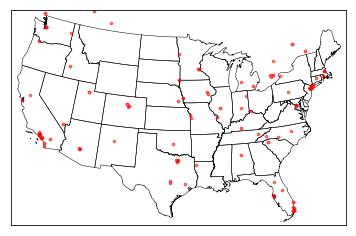

In [78]:
scale = 5

map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('./st99_d00', name='states', drawbounds=True)

# Get the location of each city and plot it
geolocator = Nominatim()
for (city, score) in cities[:100]:
    try:
        loc = geolocator.geocode(city)
    except:
        print("Except happened in geocoding {}".format(city))
        continue
    if loc is None:
        print(city)
        continue
    x, y = map(loc.longitude, loc.latitude)
    map.plot(x,y,marker='o',color='Red',markersize=score**2*scale,alpha=score**2)
plt.show()

# Tracking Frequent Terms

In [113]:
from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

#### Count for A Tourist City

In [119]:
# Change location to get other results
df_west_hollywood = df_preprocessed.filter(df_preprocessed.location == "West Hollywood, CA")

In [120]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
swremover = StopWordsRemover(inputCol="words", outputCol="words_after_removal")
track_freq_pipeline = Pipeline(stages=[tokenizer, swremover])

track_freq_pipeline_model = track_freq_pipeline.fit(df_west_hollywood)
df_west_hollywood_swremoved = track_freq_pipeline_model.transform(df_west_hollywood)

cv = CountVectorizer(vocabSize=2**16, inputCol="words_after_removal", outputCol='cv')

cv_model =  cv.fit(df_west_hollywood_swremoved)
df_west_hollywood_cv = cv_model.transform(df_west_hollywood_swremoved)

freq_count = np.zeros(len(cv_model.vocabulary))
for row in df_west_hollywood_cv.collect():
    freq_count += np.array(row.cv.toArray().tolist())
    
dict(zip(cv_model.vocabulary, freq_count))

{'name': 727.0,
 'user': 718.0,
 'url': 476.0,
 'face': 85.0,
 'heart': 68.0,
 'hollywood': 61.0,
 'west': 51.0,
 'like': 40.0,
 'red': 39.0,
 'love': 37.0,
 'time': 36.0,
 'know': 33.0,
 'get': 32.0,
 'california': 30.0,
 'right': 28.0,
 'night': 27.0,
 'good': 27.0,
 'see': 25.0,
 'tonight': 25.0,
 'one': 25.0,
 'joy': 24.0,
 'much': 24.0,
 'tears': 24.0,
 'thank': 24.0,
 'show': 24.0,
 'la': 22.0,
 're': 22.0,
 'thanks': 21.0,
 'happy': 21.0,
 'people': 20.0,
 'great': 19.0,
 'day': 19.0,
 'really': 19.0,
 'going': 19.0,
 'new': 18.0,
 'last': 18.0,
 'work': 18.0,
 'two': 18.0,
 'ca': 17.0,
 'us': 16.0,
 'smiling': 16.0,
 'need': 16.0,
 'even': 16.0,
 'hands': 16.0,
 'lol': 16.0,
 'eyes': 16.0,
 'go': 15.0,
 'make': 15.0,
 'party': 15.0,
 'fire': 15.0,
 'look': 15.0,
 'may': 14.0,
 'person': 14.0,
 'back': 14.0,
 'take': 14.0,
 'll': 14.0,
 'first': 14.0,
 'let': 14.0,
 'weho': 14.0,
 'room': 14.0,
 'today': 14.0,
 've': 13.0,
 'want': 13.0,
 'life': 13.0,
 'films': 13.0,
 'every': 

#### Count for A Traditionally Well Ranked City

In [121]:
# Change location to get other results
df_west_hollywood = df_preprocessed.filter(df_preprocessed.location == "Boulder, CO")

In [122]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
swremover = StopWordsRemover(inputCol="words", outputCol="words_after_removal")
track_freq_pipeline = Pipeline(stages=[tokenizer, swremover])

track_freq_pipeline_model = track_freq_pipeline.fit(df_west_hollywood)
df_west_hollywood_swremoved = track_freq_pipeline_model.transform(df_west_hollywood)

cv = CountVectorizer(vocabSize=2**16, inputCol="words_after_removal", outputCol='cv')

cv_model =  cv.fit(df_west_hollywood_swremoved)
df_west_hollywood_cv = cv_model.transform(df_west_hollywood_swremoved)

freq_count = np.zeros(len(cv_model.vocabulary))
for row in df_west_hollywood_cv.collect():
    freq_count += np.array(row.cv.toArray().tolist())
    
dict(zip(cv_model.vocabulary, freq_count))

{'name': 620.0,
 'user': 618.0,
 'url': 259.0,
 'face': 82.0,
 'boulder': 79.0,
 'co': 57.0,
 'job': 42.0,
 'like': 41.0,
 'hiring': 38.0,
 'careerarc': 36.0,
 'heart': 36.0,
 're': 34.0,
 'eyes': 29.0,
 'one': 28.0,
 'see': 24.0,
 'people': 23.0,
 'love': 23.0,
 'get': 22.0,
 've': 21.0,
 'going': 21.0,
 'good': 21.0,
 'go': 19.0,
 'tears': 19.0,
 'know': 18.0,
 'joy': 18.0,
 'thing': 18.0,
 'day': 17.0,
 'think': 17.0,
 'today': 17.0,
 'll': 16.0,
 'really': 16.0,
 'back': 16.0,
 'great': 16.0,
 'money': 15.0,
 'smiling': 15.0,
 'time': 15.0,
 'work': 15.0,
 'mouth': 14.0,
 'anyone': 14.0,
 'new': 14.0,
 'still': 14.0,
 'ever': 14.0,
 'look': 13.0,
 'trump': 13.0,
 'want': 13.0,
 'colorado': 13.0,
 'need': 13.0,
 'rainbow': 12.0,
 'next': 12.0,
 'us': 11.0,
 'happy': 11.0,
 'every': 11.0,
 'getting': 11.0,
 'red': 11.0,
 'also': 10.0,
 'much': 10.0,
 'person': 10.0,
 'recommend': 10.0,
 'got': 10.0,
 'past': 10.0,
 'dollar': 10.0,
 'help': 10.0,
 'hands': 10.0,
 'world': 10.0,
 'life

#### Counting for a Students Town

In [123]:
# Change location to get other results
df_west_hollywood = df_preprocessed.filter(df_preprocessed.location == "Cambridge, MA")

In [124]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
swremover = StopWordsRemover(inputCol="words", outputCol="words_after_removal")
track_freq_pipeline = Pipeline(stages=[tokenizer, swremover])

track_freq_pipeline_model = track_freq_pipeline.fit(df_west_hollywood)
df_west_hollywood_swremoved = track_freq_pipeline_model.transform(df_west_hollywood)

cv = CountVectorizer(vocabSize=2**16, inputCol="words_after_removal", outputCol='cv')

cv_model =  cv.fit(df_west_hollywood_swremoved)
df_west_hollywood_cv = cv_model.transform(df_west_hollywood_swremoved)

freq_count = np.zeros(len(cv_model.vocabulary))
for row in df_west_hollywood_cv.collect():
    freq_count += np.array(row.cv.toArray().tolist())
    
dict(zip(cv_model.vocabulary, freq_count))

{'name': 1088.0,
 'user': 1083.0,
 'url': 394.0,
 'face': 86.0,
 'cambridge': 59.0,
 'like': 52.0,
 'one': 47.0,
 'ma': 41.0,
 'time': 38.0,
 'see': 35.0,
 'get': 33.0,
 'know': 30.0,
 'new': 27.0,
 'heart': 27.0,
 'us': 27.0,
 'today': 27.0,
 'boston': 27.0,
 'job': 27.0,
 'good': 27.0,
 're': 26.0,
 'work': 26.0,
 'hiring': 26.0,
 'joy': 25.0,
 'tears': 25.0,
 'careerarc': 24.0,
 'go': 24.0,
 'people': 24.0,
 'love': 23.0,
 'thank': 23.0,
 'want': 22.0,
 'much': 20.0,
 'back': 20.0,
 'think': 20.0,
 'shit': 20.0,
 'need': 20.0,
 'thanks': 19.0,
 'harvard': 19.0,
 'going': 19.0,
 've': 18.0,
 'right': 18.0,
 'tonight': 18.0,
 'way': 18.0,
 'thinking': 18.0,
 'lol': 18.0,
 'really': 17.0,
 'great': 17.0,
 'first': 17.0,
 'take': 17.0,
 'things': 16.0,
 'game': 16.0,
 'life': 16.0,
 'man': 16.0,
 'please': 15.0,
 'also': 15.0,
 'last': 15.0,
 'trump': 15.0,
 'oh': 15.0,
 'day': 15.0,
 'come': 15.0,
 'crying': 15.0,
 'massachusetts': 15.0,
 'years': 14.0,
 'person': 14.0,
 'say': 14.0,
 